# Residual Integration Neural Net

# Problem statement :

Let us consider a dynamical system, whose time-varying state $X_t$ is governed by the following ordinary differential equation (ODE):

\begin{equation}
\frac{dX_t}{dt}= F(t,X_t)
\label{eq:sys dyn}
\end{equation}

where $F$ is the dynamical operator. Most of the time, this ODE cannot be solved analytically and numerical integration techniques using discrete approximations are implemented. 

In this work, we focus on explicit integration schemes. A one-step explicit integration scheme is defined as: 

\begin{equation}
\label{eq:int_gen_schm}
X_{t_{n+1}} = X_{t_{n}} + h\Phi(t_{n},X_{t_{n}},h)
\end{equation}

with $\Phi(t_{n},X_{t_{n}},h)$ a numerical integration operator. Here, we aim to learn a prediction operator based on $\Phi$ and an approximation of the dynamical model $F(t,X_t)$ so that the forecasting error (typically, a one-step-ahead error) is minimized.

In this notebook, will learn an approximation of both $\Phi$ and $F(t,X_t)$ of the lorenz 63 model given a poorly sampled time series.


In [1]:
import sys
sys.path.append('/homes/s17ouala/Bureau/Sanssauvegarde/Complement/RINN/LearningODEIntegrationSchemes')
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
def RMSE(a,b): 
    return np.sqrt(np.mean((a-b)**2))
from tqdm import tqdm

In [2]:
# dataset parameters
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 4000.01 #7500.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
init_cat = catalog.analogs
#training data
batch_size = 100

In [3]:
new_dt = 0.3
GD.dt_integration = new_dt
keep_ratio = int(new_dt/0.01)
catalog.analogs    = init_cat[::keep_ratio,:][:-1]
catalog.successors = init_cat[::keep_ratio,:][1:]
xt.values          = xt.values[::keep_ratio,:]
X_train = np.reshape(catalog.analogs[:13300,:],(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))
Grad_t  = np.gradient(X_train)[1]/GD.dt_integration
Y_train = np.reshape(catalog.successors[:13300,:],(int(catalog.analogs.shape[0]/batch_size),batch_size,catalog.analogs.shape[1]))

In [4]:
import pickle
data_dict = {}
data_dict['X_train'] = X_train
data_dict['Y_train'] = Y_train
data_dict['Grad_t']  = Grad_t
data_dict['X_test']  = xt.values
output = open('train_data_dt_03.pkl', 'wb')
pickle.dump(data_dict, output)
output.close()

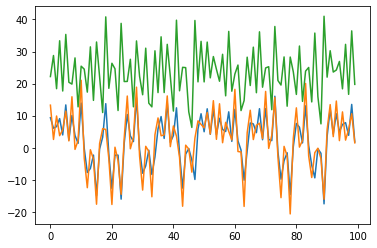

In [5]:
plt.plot(X_train[0,:,:])

In [6]:
# generating training data
class GD2:
    model = 'Adv_Dif_1D_Real'
    class parameters:
        w = -0.5
        x0 = 0.5
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 1000.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog2, xt2, yo2 = generate_data(GD2)
#AnDA_RMSE(catalog.true_solution,catalog.euler_integration)
#AnDA_RMSE(catalog.true_solution,catalog.num_integration)
#training data
batch_size_lin = catalog2.true_solution[:-10-1,:].shape[0]
X_train_lin = np.reshape(catalog2.true_solution[:-10-1,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))
Grad_t_lin  = np.reshape(np.gradient(catalog2.true_solution[:-10-1,0])/GD.dt_integration,(X_train_lin.shape))
Y_train_lin = np.reshape(catalog2.true_solution[1:-10,:],(int(catalog2.true_solution[1:-10,:].shape[0]/batch_size_lin),batch_size_lin,catalog2.true_solution[1:-10,:].shape[1]))

In [7]:
order=11 #number of stages of the runge kutta scheme

params = {}#NN parameters 
params['transition_layers']=1
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=3
params['dim_observations'] = 3
params['dim_output']=3
params['dim_hidden']=3
params['dt_integration']=GD.dt_integration
params['ntrain']=[0,1000]
params['lr']=0.001
pretrained = False
path = 'RINN_L63_dt_integration_03_order_11'

# Learn dynamical and integration models, stop when loss ~ 0.2

In [8]:
np.random.seed(0)
torch.manual_seed(0)
class applyRK_Constraints(object):
        def __init__(self, frequency=1):
            self.frequency = frequency
    
        def __call__(self, module):
            if hasattr(module, 'b'):
                module.b.data = (torch.abs(module.b.data))
                module.b.data  =  ((module.b.data) / (module.b.data).sum(1,keepdim = True).expand_as(module.b.data))
            if hasattr(module, 'c'):
                module.c.data = module.c.data
                module.c.data[:,0] = 0
                module.c.data = module.c.data.sub_(torch.min(module.c.data)).div_(torch.max(module.c.data) - torch.min(module.c.data)).sort()[0]
class FC_net_true(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true, self).__init__()
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            arg = [GD.parameters.sigma,GD.parameters.rho,GD.parameters.beta]
            grad = Variable(torch.zeros((inp.size())))
            grad[:,0] = arg[0]*(inp[:,1]-inp[:,0]);
            grad[:,1] = inp[:,0]*(arg[1]-inp[:,2])-inp[:,1];
            grad[:,2] = inp[:,0]*inp[:,1] - arg[2]*inp[:,2];
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return grad
model_true  = FC_net_true(params)

class FC_net_true_L96(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_true_L96, self).__init__()
        def forward(self, S):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            J = 40
            F = 8
            x = torch.zeros(S.shape[0],J);
            x[:,0] = (S[:,1]-S[:,J-2])*S[:,J-1]-S[:,0];
            x[:,1] = (S[:,2]-S[:,J-1])*S[:,0]-S[:,1];
            x[:,J-1] = (S[:,0]-S[:,J-3])*S[:,J-2]-S[:,J-1];
            for j in range(2,J-1):
                x[:,j] = (S[:,j+1]-S[:,j-2])*S[:,j-1]-S[:,j];
            dS = x + F;
#            dS  = np.array([x_1,x_2,x_3]);
#            grad = self.outputLayer(aug_vect)
            return dS
model_true_L96  = FC_net_true_L96(params)

class FC_net(torch.nn.Module):
        def __init__(self, params):
            super(FC_net, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output'])])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']) 
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = Variable(torch.zeros((inp.size()[0],params['bi_linear_layers'])))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = FC_net(params)
class FC_net_lin(torch.nn.Module):
        def __init__(self, params):
            super(FC_net_lin, self).__init__()
            self.coef_mdl =GD2.parameters.w
        def forward(self, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            grad = self.coef_mdl*inp
            return grad
model_lin  = FC_net_lin(params)
class INT_net(torch.nn.Module):
        def __init__(self, params,order):
            super(INT_net, self).__init__()
            self.Dyn_net = model
            self.Dyn_net_lin = model_lin
            self.Dyn_net_True = model_true
            self.Dyn_net_True_L96 = model_true_L96
            a = 0.*np.tril(np.random.uniform(size=(1,order,order)),k=-1)
            b = 0.*np.random.uniform(size=(1,order))
            c = 0.01*np.random.uniform(size=(1,order))
            self.a = torch.nn.Parameter(torch.from_numpy(a[:,:,:]).float(),requires_grad = True)
            self.b = torch.nn.Parameter(torch.from_numpy(b).float(),requires_grad = True)
            self.c = torch.nn.Parameter(torch.from_numpy(c).float(),requires_grad = True)
        def lin_flow(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_lin(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_lin(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            gain = pred[0,:]/(inp[0,:])
            return pred ,k[0], gain 
        def flow_True_Model(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp
        def flow_True_Model_L96(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net_True_L96(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net_True_L96(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp        
        def flow_RK45_True_Model(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1     
        def flow_RK45_True_Model_L96(self, inp,dt,order = 4):
            k1    = self.Dyn_net_True_L96(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net_True_L96(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net_True_L96(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net_True_L96(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1    
        def flow_RK45(self, inp,dt,order = 4):
            k1    = self.Dyn_net(inp)
            inp_k2 = inp + 0.5*dt*k1
            k2  = self.Dyn_net(inp_k2)
            inp_k3 = inp + 0.5*dt*k2       
            k3   = self.Dyn_net(inp_k3)
            inp_k4 = inp + dt*k3          
            k4   = self.Dyn_net(inp_k4)            
            pred = inp +dt*(k1+2*k2+2*k3+k4)/6    
            return pred, k1        
        def opti_gain_lin(self, h_int, inp, order):
            gain = Variable(torch.zeros(h_int.size()).float())
            for i in range(h_int.shape[0]):
                pred ,tmp, tmpp =self.lin_flow(inp, h_int[i], order)
                gain[i] = tmpp[0]
                del pred, tmp, tmpp
            return gain
        def implicit_scheme(self, inp, inpt1, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inpt1))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp        
        def forward(self, inp, dt, order):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            k = [(self.Dyn_net(inp))]
            for i in range(1,order):
                coef_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
                for j in range(0,i):
                    if j ==0:
                        if i == 1:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]).expand_as(k[j])
                        else:
                            coef_sum = coef_sum + k[j]*(self.c[:,i]-self.a[:,i,1:i].sum(1)).expand_as(k[j])
                    else :
                        coef_sum = coef_sum + k[j]*self.a[:,i,j].expand_as(k[j])
                rk_inp = inp+dt*coef_sum        
                k.append(self.Dyn_net(rk_inp))
            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()))
            for i in range(0,order): 
                pred_sum = pred_sum+k[i]*self.b[:,i].expand_as(k[i])
            pred = inp +dt*pred_sum
            return pred ,k[0], inp

In [9]:
x = Variable(torch.from_numpy(X_train).float())
y = Variable(torch.from_numpy(Y_train).float())
z = Variable(torch.from_numpy(Grad_t).float())

# Construct our model by instantiating the class defined above
    
modelRINN = INT_net(params,order)
    # Construct our loss function and an Optimizer. The call to model.parameters()

if pretrained :
        modelRINN.load_state_dict(torch.load(path+'.pt'))
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(modelRINN.parameters(), lr = 0.001)

In [10]:
#modelRINN.load_state_dict(torch.load('RINN_L63_dt' + str(GD.dt_integration)+ '.pt'))

In [11]:
clipper = applyRK_Constraints()
clip_value = 1.0
print ('Learning dynamical model')
for t in range(params['ntrain'][1]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred ,grad , inp = modelRINN(x[b,:,:],params['dt_integration'],order)
            #predi ,grad , inp = modelRINN.implicit_scheme(x[b,:,:],y[b,:,:],params['dt_integration'],order)
            pred1 ,tmp , tmp = modelRINN(x[b,:,:],0.5*params['dt_integration'],order)
            pred1 ,tmp , tmp = modelRINN(pred1,0.5*params['dt_integration'],order)
            #gain_op = modelRINN.opti_gain_lin(h_int, x_lin[0,:1,:],order)
            #loss_opti = customized_loss((gain_op), gain_true)
            # Compute and print loss
            loss_pred1 = criterion(pred, y[b,:,:])
            #loss_pred_i = criterion(predi, y[b,:,:])            
            loss_pred2 = criterion(pred1, y[b,:,:])
            loss = loss_pred1+loss_pred2#+loss_pred_i+loss_pred2# + loss_opti
            if not (np.isnan(loss.data.numpy())):
                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad() 
                loss.backward()
                optimizer.step()
                #torch.nn.utils.clip_grad_norm_(modelRINN.parameters(),5)
                #for p in modelRINN.parameters():
                #    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
                #modelRINN.apply(clipper)
                if t % clipper.frequency == 0:
                    modelRINN.apply(clipper)
        print(t,loss)
        torch.save(modelRINN.state_dict(), path+'_.pt')
        #if t > 700:
        #    for param_group in optimizer.param_groups:
        #        param_group['lr'] = 0.0001

Learning dynamical model
0 tensor(247.9817, grad_fn=<AddBackward0>)
1 tensor(215.5992, grad_fn=<AddBackward0>)
2 tensor(195.3604, grad_fn=<AddBackward0>)
3 tensor(175.4928, grad_fn=<AddBackward0>)
4 tensor(155.3710, grad_fn=<AddBackward0>)
5 tensor(132.4425, grad_fn=<AddBackward0>)
6 tensor(104.9443, grad_fn=<AddBackward0>)
7 tensor(87.2959, grad_fn=<AddBackward0>)
8 tensor(81.1983, grad_fn=<AddBackward0>)
9 tensor(73.5196, grad_fn=<AddBackward0>)
10 tensor(65.3224, grad_fn=<AddBackward0>)
11 tensor(58.2806, grad_fn=<AddBackward0>)
12 tensor(54.6544, grad_fn=<AddBackward0>)
13 tensor(48.2393, grad_fn=<AddBackward0>)
14 tensor(43.5870, grad_fn=<AddBackward0>)
15 tensor(39.7350, grad_fn=<AddBackward0>)
16 tensor(36.3692, grad_fn=<AddBackward0>)
17 tensor(32.9382, grad_fn=<AddBackward0>)
18 tensor(29.3213, grad_fn=<AddBackward0>)
19 tensor(25.7162, grad_fn=<AddBackward0>)
20 tensor(22.4586, grad_fn=<AddBackward0>)
21 tensor(19.8001, grad_fn=<AddBackward0>)
22 tensor(17.7534, grad_fn=<AddB

192 tensor(0.0243, grad_fn=<AddBackward0>)
193 tensor(0.0243, grad_fn=<AddBackward0>)
194 tensor(0.0243, grad_fn=<AddBackward0>)
195 tensor(0.0243, grad_fn=<AddBackward0>)
196 tensor(0.0243, grad_fn=<AddBackward0>)
197 tensor(0.0243, grad_fn=<AddBackward0>)
198 tensor(0.0243, grad_fn=<AddBackward0>)
199 tensor(0.0244, grad_fn=<AddBackward0>)
200 tensor(0.0244, grad_fn=<AddBackward0>)
201 tensor(0.0244, grad_fn=<AddBackward0>)
202 tensor(0.0244, grad_fn=<AddBackward0>)
203 tensor(0.0244, grad_fn=<AddBackward0>)
204 tensor(0.0244, grad_fn=<AddBackward0>)
205 tensor(0.0245, grad_fn=<AddBackward0>)
206 tensor(0.0245, grad_fn=<AddBackward0>)
207 tensor(0.0245, grad_fn=<AddBackward0>)
208 tensor(0.0245, grad_fn=<AddBackward0>)
209 tensor(0.0245, grad_fn=<AddBackward0>)
210 tensor(0.0245, grad_fn=<AddBackward0>)
211 tensor(0.0245, grad_fn=<AddBackward0>)
212 tensor(0.0245, grad_fn=<AddBackward0>)
213 tensor(0.0245, grad_fn=<AddBackward0>)
214 tensor(0.0245, grad_fn=<AddBackward0>)
215 tensor(

383 tensor(0.0426, grad_fn=<AddBackward0>)
384 tensor(0.0454, grad_fn=<AddBackward0>)
385 tensor(0.0480, grad_fn=<AddBackward0>)
386 tensor(0.0522, grad_fn=<AddBackward0>)
387 tensor(0.0506, grad_fn=<AddBackward0>)
388 tensor(0.0470, grad_fn=<AddBackward0>)
389 tensor(0.0445, grad_fn=<AddBackward0>)
390 tensor(0.0424, grad_fn=<AddBackward0>)
391 tensor(0.0413, grad_fn=<AddBackward0>)
392 tensor(0.0404, grad_fn=<AddBackward0>)
393 tensor(0.0398, grad_fn=<AddBackward0>)
394 tensor(0.0391, grad_fn=<AddBackward0>)
395 tensor(0.0386, grad_fn=<AddBackward0>)
396 tensor(0.0381, grad_fn=<AddBackward0>)
397 tensor(0.0376, grad_fn=<AddBackward0>)
398 tensor(0.0373, grad_fn=<AddBackward0>)
399 tensor(0.0369, grad_fn=<AddBackward0>)
400 tensor(0.0366, grad_fn=<AddBackward0>)
401 tensor(0.0362, grad_fn=<AddBackward0>)
402 tensor(0.0358, grad_fn=<AddBackward0>)
403 tensor(0.0356, grad_fn=<AddBackward0>)
404 tensor(0.0354, grad_fn=<AddBackward0>)
405 tensor(0.0351, grad_fn=<AddBackward0>)
406 tensor(

574 tensor(0.0301, grad_fn=<AddBackward0>)
575 tensor(0.0300, grad_fn=<AddBackward0>)
576 tensor(0.0300, grad_fn=<AddBackward0>)
577 tensor(0.0299, grad_fn=<AddBackward0>)
578 tensor(0.0299, grad_fn=<AddBackward0>)
579 tensor(0.0298, grad_fn=<AddBackward0>)
580 tensor(0.0297, grad_fn=<AddBackward0>)
581 tensor(0.0296, grad_fn=<AddBackward0>)
582 tensor(0.0296, grad_fn=<AddBackward0>)
583 tensor(0.0295, grad_fn=<AddBackward0>)
584 tensor(0.0294, grad_fn=<AddBackward0>)
585 tensor(0.0293, grad_fn=<AddBackward0>)
586 tensor(0.0293, grad_fn=<AddBackward0>)
587 tensor(0.0292, grad_fn=<AddBackward0>)
588 tensor(0.0292, grad_fn=<AddBackward0>)
589 tensor(0.0291, grad_fn=<AddBackward0>)
590 tensor(0.0291, grad_fn=<AddBackward0>)
591 tensor(0.0291, grad_fn=<AddBackward0>)
592 tensor(0.0290, grad_fn=<AddBackward0>)
593 tensor(0.0290, grad_fn=<AddBackward0>)
594 tensor(0.0289, grad_fn=<AddBackward0>)
595 tensor(0.0289, grad_fn=<AddBackward0>)
596 tensor(0.0288, grad_fn=<AddBackward0>)
597 tensor(

765 tensor(0.0250, grad_fn=<AddBackward0>)
766 tensor(0.0250, grad_fn=<AddBackward0>)
767 tensor(0.0249, grad_fn=<AddBackward0>)
768 tensor(0.0249, grad_fn=<AddBackward0>)
769 tensor(0.0249, grad_fn=<AddBackward0>)
770 tensor(0.0249, grad_fn=<AddBackward0>)
771 tensor(0.0249, grad_fn=<AddBackward0>)
772 tensor(0.0249, grad_fn=<AddBackward0>)
773 tensor(0.0249, grad_fn=<AddBackward0>)
774 tensor(0.0248, grad_fn=<AddBackward0>)
775 tensor(0.0248, grad_fn=<AddBackward0>)
776 tensor(0.0248, grad_fn=<AddBackward0>)
777 tensor(0.0248, grad_fn=<AddBackward0>)
778 tensor(0.0248, grad_fn=<AddBackward0>)
779 tensor(0.0247, grad_fn=<AddBackward0>)
780 tensor(0.0247, grad_fn=<AddBackward0>)
781 tensor(0.0247, grad_fn=<AddBackward0>)
782 tensor(0.0247, grad_fn=<AddBackward0>)
783 tensor(0.0247, grad_fn=<AddBackward0>)
784 tensor(0.0246, grad_fn=<AddBackward0>)
785 tensor(0.0246, grad_fn=<AddBackward0>)
786 tensor(0.0246, grad_fn=<AddBackward0>)
787 tensor(0.0246, grad_fn=<AddBackward0>)
788 tensor(

956 tensor(0.0212, grad_fn=<AddBackward0>)
957 tensor(0.0212, grad_fn=<AddBackward0>)
958 tensor(0.0212, grad_fn=<AddBackward0>)
959 tensor(0.0212, grad_fn=<AddBackward0>)
960 tensor(0.0212, grad_fn=<AddBackward0>)
961 tensor(0.0212, grad_fn=<AddBackward0>)
962 tensor(0.0212, grad_fn=<AddBackward0>)
963 tensor(0.0212, grad_fn=<AddBackward0>)
964 tensor(0.0212, grad_fn=<AddBackward0>)
965 tensor(0.0212, grad_fn=<AddBackward0>)
966 tensor(0.0212, grad_fn=<AddBackward0>)
967 tensor(0.0212, grad_fn=<AddBackward0>)
968 tensor(0.0211, grad_fn=<AddBackward0>)
969 tensor(0.0211, grad_fn=<AddBackward0>)
970 tensor(0.0211, grad_fn=<AddBackward0>)
971 tensor(0.0211, grad_fn=<AddBackward0>)
972 tensor(0.0211, grad_fn=<AddBackward0>)
973 tensor(0.0211, grad_fn=<AddBackward0>)
974 tensor(0.0211, grad_fn=<AddBackward0>)
975 tensor(0.0211, grad_fn=<AddBackward0>)
976 tensor(0.0211, grad_fn=<AddBackward0>)
977 tensor(0.0211, grad_fn=<AddBackward0>)
978 tensor(0.0210, grad_fn=<AddBackward0>)
979 tensor(

# Short term forecast

In [12]:
nb_steps_pred = 1000
t_pred = nb_steps_pred * GD.dt_integration
y_pred_init=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(xt.values[0,:],(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())
y_pred_init[0,:] = xt.values[0,:]
for i in range(1,nb_steps_pred):
    y_pred_init[i,:] = modelRINN(tmp,params['dt_integration'],order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred_init[i,:] ,(1,params['dim_output']))).float())

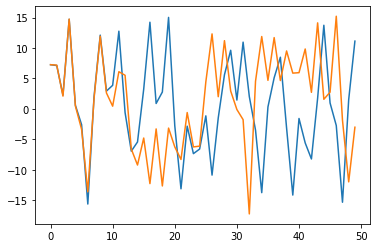

In [13]:
plt.plot(xt.values[:50,0])
plt.plot(y_pred_init[:50,0])

In [14]:
print('RMSE t+dt : ',RMSE(xt.values[1,:],y_pred_init[1,:]))
print('RMSE t+4dt : ',RMSE(xt.values[4,:],y_pred_init[4,:]))

RMSE t+dt :  0.07734547067220963
RMSE t+4dt :  0.23135894872473262


## Perfs of the trained model and integration scheme (1D)


In [15]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()

import sympy as sp
xt, h = sp.symbols('xt h')

In [16]:
# computing analytic form of the integration scheme
k = [(modelRINN.Dyn_net_lin(xt))]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((modelRINN.Dyn_net_lin(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [17]:
# RK4 analytic integration scheme
grad = modelRINN.Dyn_net_lin(xt)
k1   = modelRINN.Dyn_net_lin(xt)
k2   = modelRINN.Dyn_net_lin(xt+0.5*h*k1)
k3   = modelRINN.Dyn_net_lin(xt+0.5*h*k2)
k4   = modelRINN.Dyn_net_lin(xt+h*k3)            
xt_1RK4 = xt +h*(k1+2*k2+2*k3+k4)/6

gRK4 = xt_1RK4.factor(xt)/xt

In [18]:
# stability graph
hi = np.arange(0,20+0.000001,0.01)
gainRK4 = np.zeros_like(hi)
for i in range(len(hi)):
    gainRK4[i] = np.abs(gRK4.evalf(subs={h: hi[i]}))
gainE = np.zeros_like(hi)
for i in range(len(hi)):
    gainE[i] = np.abs(1-0.5*hi[i])
gain = np.zeros_like(hi)
for i in range(len(hi)):
    gain[i] = np.abs(g.evalf(subs={h: hi[i]}))

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


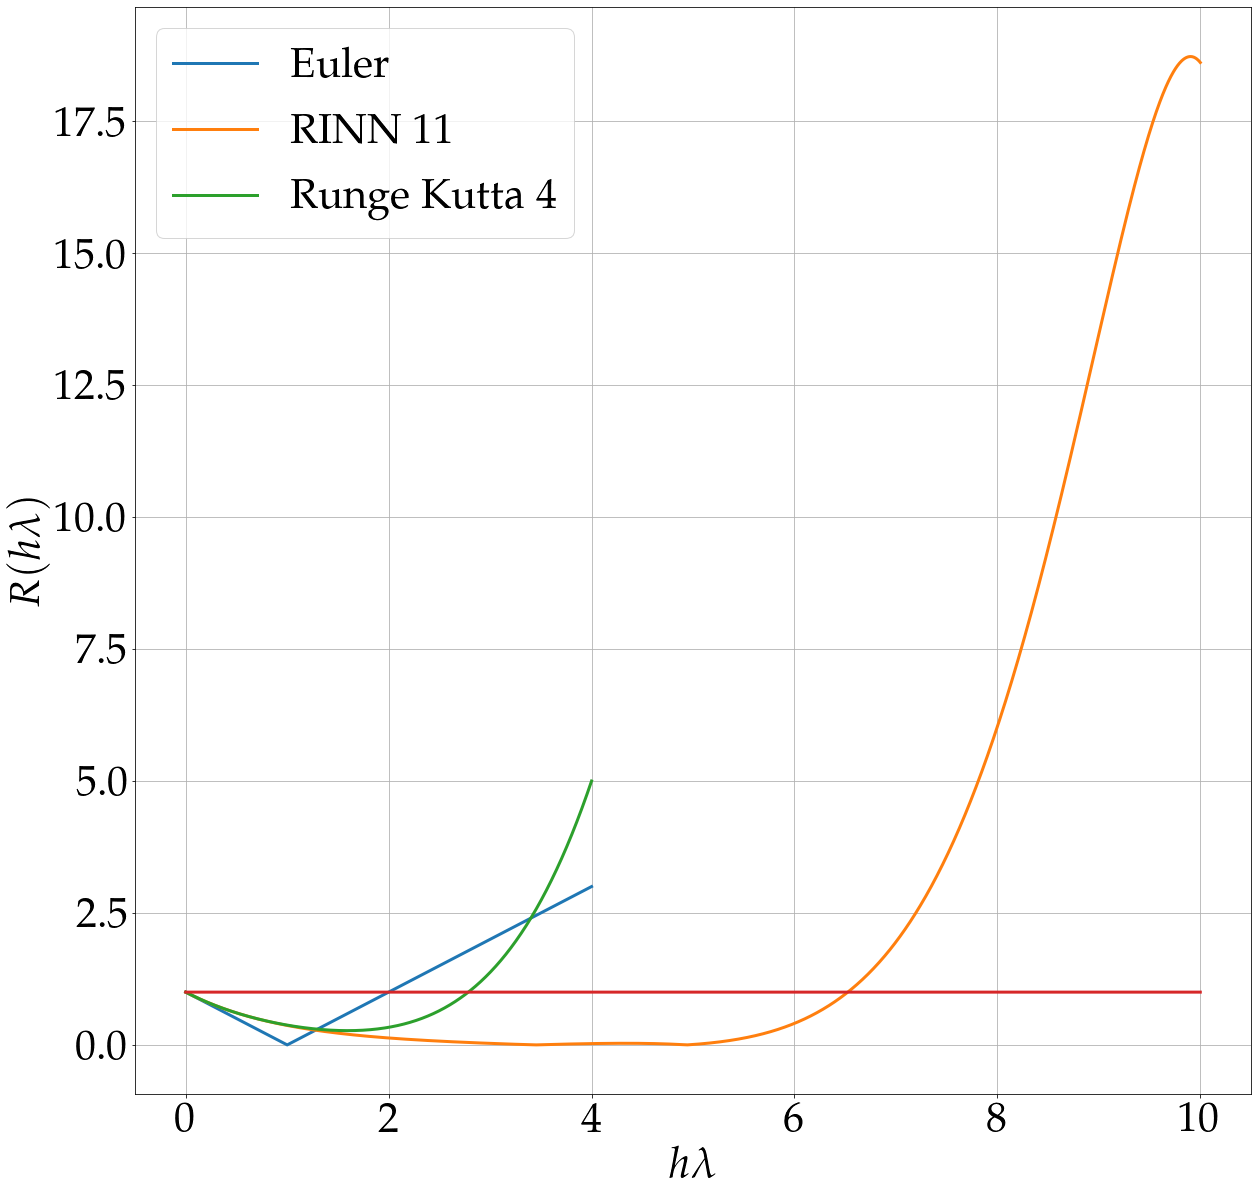

In [19]:
length_h = hi.shape[0]
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.plot(hi[:(length_h-1200)]*0.5,gainE[:(length_h-1200)],label = 'Euler',lw = 3)
plt.plot(hi[:length_h]*0.5,gain[:length_h],label = 'RINN 11',lw = 3)
plt.plot(hi[:(length_h-1200)]*0.5,gainRK4[:(length_h-1200)],label = 'Runge Kutta 4',lw = 3)
plt.plot(hi[:length_h]*0.5,np.ones_like(gainRK4[:length_h]),lw = 3)
#plt.plot(hi[:600],np.abs(ff[-1].data.numpy()[:600]))
plt.xlabel('$h\lambda$')
plt.ylabel('$R(h\lambda)$')
plt.grid()
plt.legend()

In [20]:
modelRINN.b.sum() # RK constraint respected :)

tensor(1., grad_fn=<SumBackward0>)

In [21]:
# computing analytic form of the integration scheme
a=modelRINN.a.clone().data.numpy()
b=modelRINN.b.clone().data.numpy()
c=modelRINN.c.clone().data.numpy()
xt, h, lam = sp.symbols('xt h \lambda')
k = [lam*xt]
for i in range(1,order):
    coef_sum = 0
    for j in range(0,i):
        if j ==0:
            if i == 1:
                coef_sum = coef_sum + k[j]*(c[:,i])
            else:
                coef_sum = coef_sum + k[j]*(c[:,i]-a[:,i,1:i].sum(1))
        else :
            coef_sum = coef_sum + k[j]*a[:,i,j]
    rk_inp = xt+h*coef_sum        
    k.append((lam*(rk_inp)))
#            pred_sum = torch.autograd.Variable(torch.zeros(k[0].size()).double())
pred_sum = 0   
for i in range(0,order): 
    pred_sum = pred_sum+k[i]*b[:,i]
    xt_1 = xt +h*pred_sum
# extracting the gain factor
g = xt_1.factor(xt)/xt

In [22]:
g

6.00350449389582e-9*\lambda**11*h**11 + 1.66699591657265e-7*\lambda**10*h**10 + 2.37818433222245e-6*\lambda**9*h**9 + 2.55081540393286e-5*\lambda**8*h**8 + 0.000214769564619094*\lambda**7*h**7 + 0.00151028650060506*\lambda**6*h**6 + 0.0088264862662529*\lambda**5*h**5 + 0.0427338227499699*\lambda**4*h**4 + 0.169157806789522*\lambda**3*h**3 + 0.502135936364188*\lambda**2*h**2 + 1.00000002147863*\lambda*h + 1.0

# Perfs 2D

In [23]:
# generating training data
class GD:
    model = 'Adv_Dif_1D'
    class parameters:
        w = -0.1+1.0j
        x0 = 0.5+0.5j
        t0 = 0
    dt_integration =0.01# integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0]) # indices of the observed variables
    nb_loop_train = 60.1 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 2.0 # variance of the observation error to generate observation
    
# run the data generation
catalog, xt, yo = generate_data(GD)
#training data
batch_size = catalog.true_solution[:-10-1,:].shape[0]
X_train_r = np.reshape(catalog.true_solution.real[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
X_train_i = np.reshape(catalog.true_solution.imag[:-10-1,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_r = np.reshape(catalog.true_solution.real[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))
Y_train_i = np.reshape(catalog.true_solution.imag[1:-10,:],(int(catalog.true_solution[1:-10,:].shape[0]/batch_size),batch_size,catalog.true_solution[1:-10,:].shape[1]))

In [24]:
#extracting integration scheme params
a=modelRINN.a.clone().data.numpy()[0,:,:]
b=modelRINN.b.clone().data.numpy()[0,:]
c=modelRINN.c.clone().data.numpy()[0,:]

a[:,0] = c[:] - a[:,:].sum(axis = 1)

import sympy as sp
x1,re_w,h  = sp.symbols('x1 re_w h',real=True)
x2,im_w    = sp.symbols('x2 im_w',real=True)

xt   = sp.symbols('x1+ix2')
lamb = re_w+sp.I*im_w

In [25]:
rz = np.arange(-10,10+0.000001,0.01)
iz = np.arange(-10,10+0.000001,0.01)
rz, iz = np.meshgrid(rz,iz)
z  = rz+iz*1.j

In [26]:
GRINN = np.zeros_like(z)*np.nan
list_g = []
list_x = []
list_y = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
        if tmp<1:
            GRINN[i,j] = np.abs(1+z[i,j]*np.dot(np.dot(b.T,np.linalg.inv(np.eye(a.shape[0])-z[i,j]*a)),np.ones_like(b)))
            list_g.append(GRINN[i,j].real)
            list_x.append(z[i,j].real)
            list_y.append(z[i,j].imag)

100%|██████████| 2001/2001 [04:48<00:00,  6.94it/s]


In [27]:
GE = np.zeros_like(z)*np.nan
list_gE = []
list_xE = []
list_yE = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j])
        if tmp<1:
            GE[i,j] = tmp
            list_gE.append(GE[i,j].real)
            list_xE.append(z[i,j].real)
            list_yE.append(z[i,j].imag)

100%|██████████| 2001/2001 [00:08<00:00, 231.18it/s]


In [28]:
GRK4 = np.zeros_like(z)*np.nan
ark4 = np.array([[0,0,0,0],[1/2,0,0,0],[0,1/2,0,0],[0,0,1,0]])
brk4 = np.array([1/6,1/3,1/3,1/6])

list_gRK4 = []
list_xRK4 = []
list_yRK4 = []
for i in tqdm(range(z.shape[0])):
    for j in range(z.shape[1]):
        tmp = np.abs(1+z[i,j]*np.dot(np.dot(brk4.T,np.linalg.inv(np.eye(ark4.shape[0])-z[i,j]*ark4)),np.ones_like(brk4)))
        if tmp<1:
            GRK4[i,j] = tmp
            list_gRK4.append(GRK4[i,j].real)
            list_xRK4.append(z[i,j].real)
            list_yRK4.append(z[i,j].imag)

100%|██████████| 2001/2001 [01:41<00:00, 19.64it/s]


Text(0, 0.5, '$Imag(h\\lambda)$')

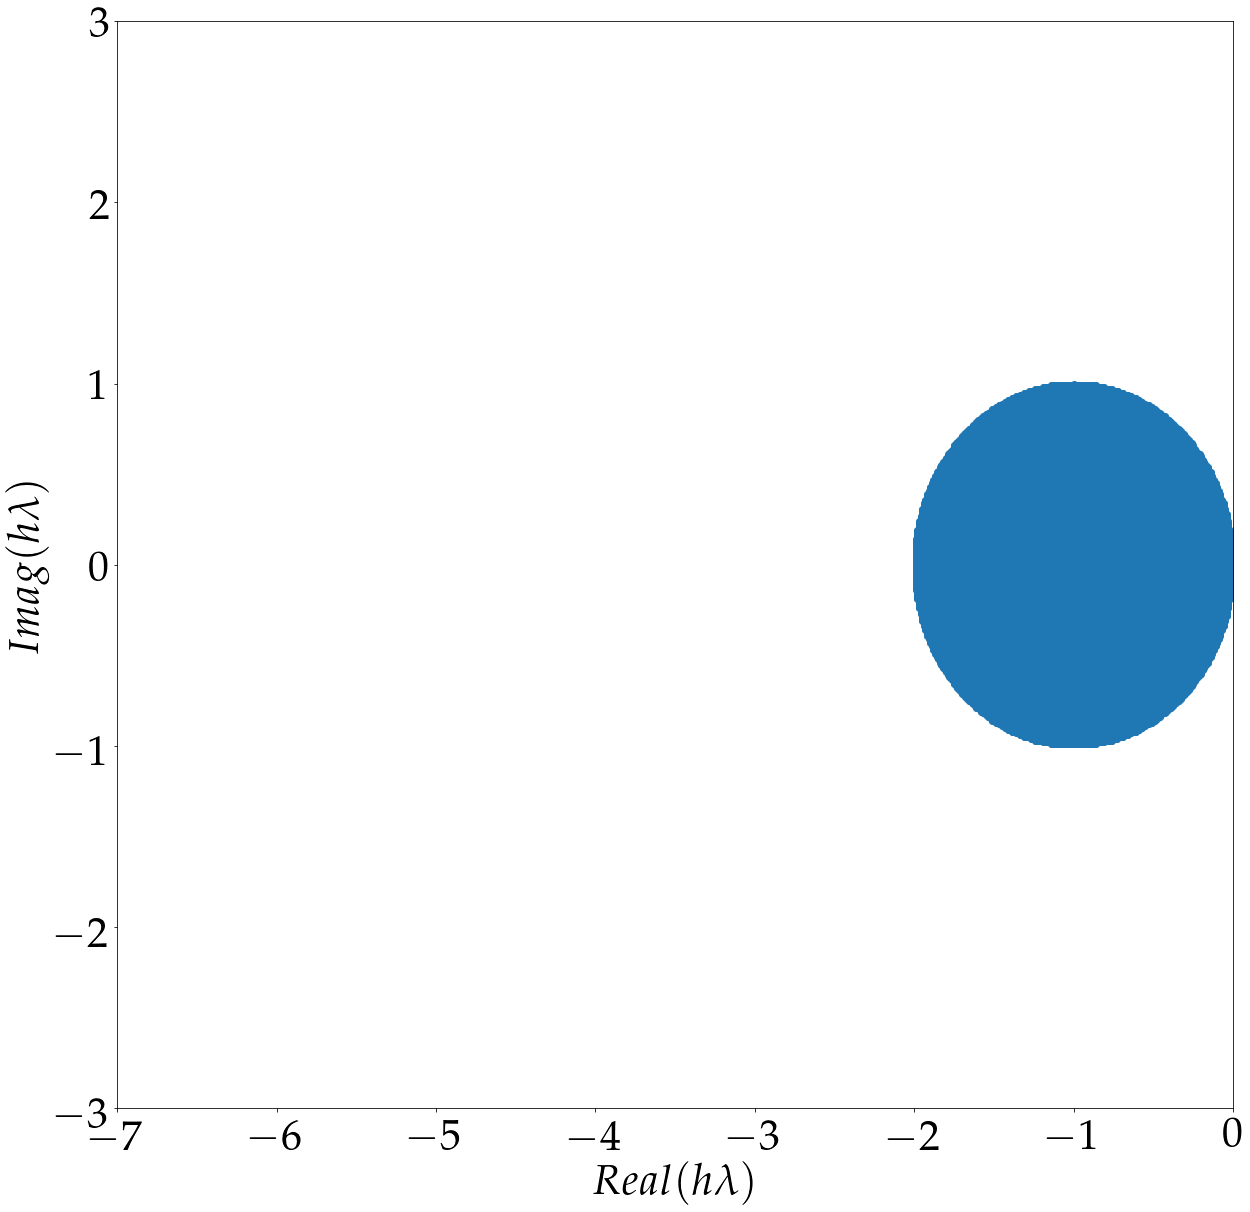

In [29]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_xE),np.array(list_yE))
plt.plot(-hi[:399]*0.5,np.zeros_like(gainE[:length_h][np.where(gainE[:length_h]<1)]),lw = 3)
plt.xlim(-7,0)
plt.ylim(-3,3)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')

(-3.0, 3.0)

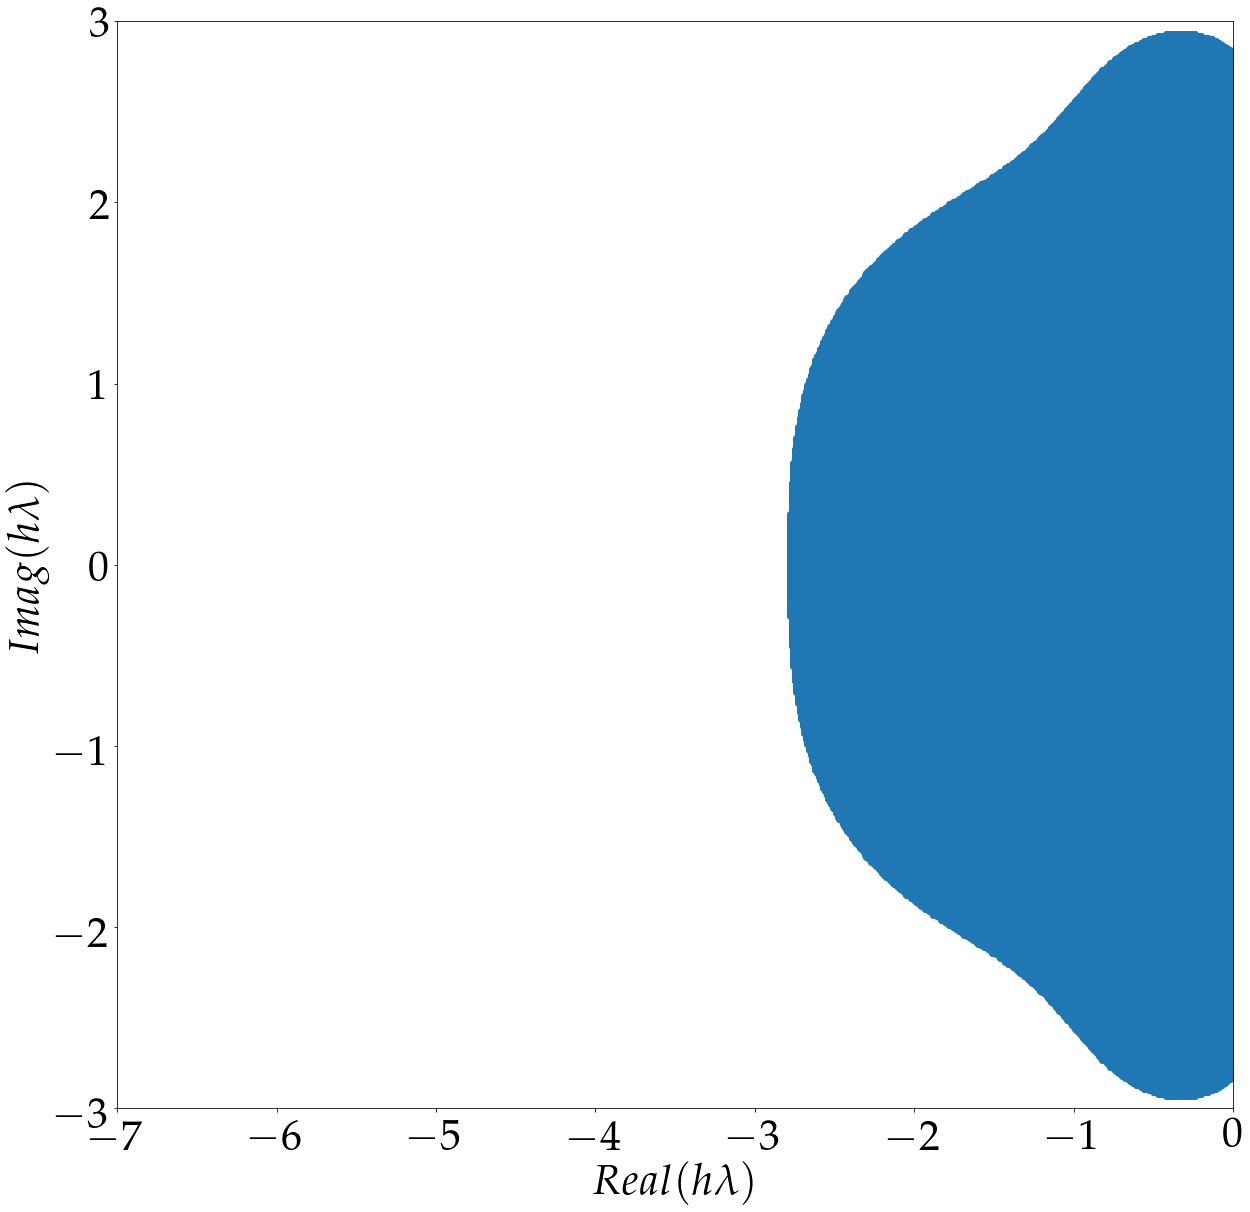

In [30]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))
plt.scatter(np.array(list_xRK4),np.array(list_yRK4))
plt.plot(-hi[:557]*0.5,np.zeros_like(gainRK4[:length_h][np.where(gainRK4[:length_h]<1)]),lw = 3)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
plt.xlim(-7,0)
plt.ylim(-3,3)

(-7.0, 7.0)

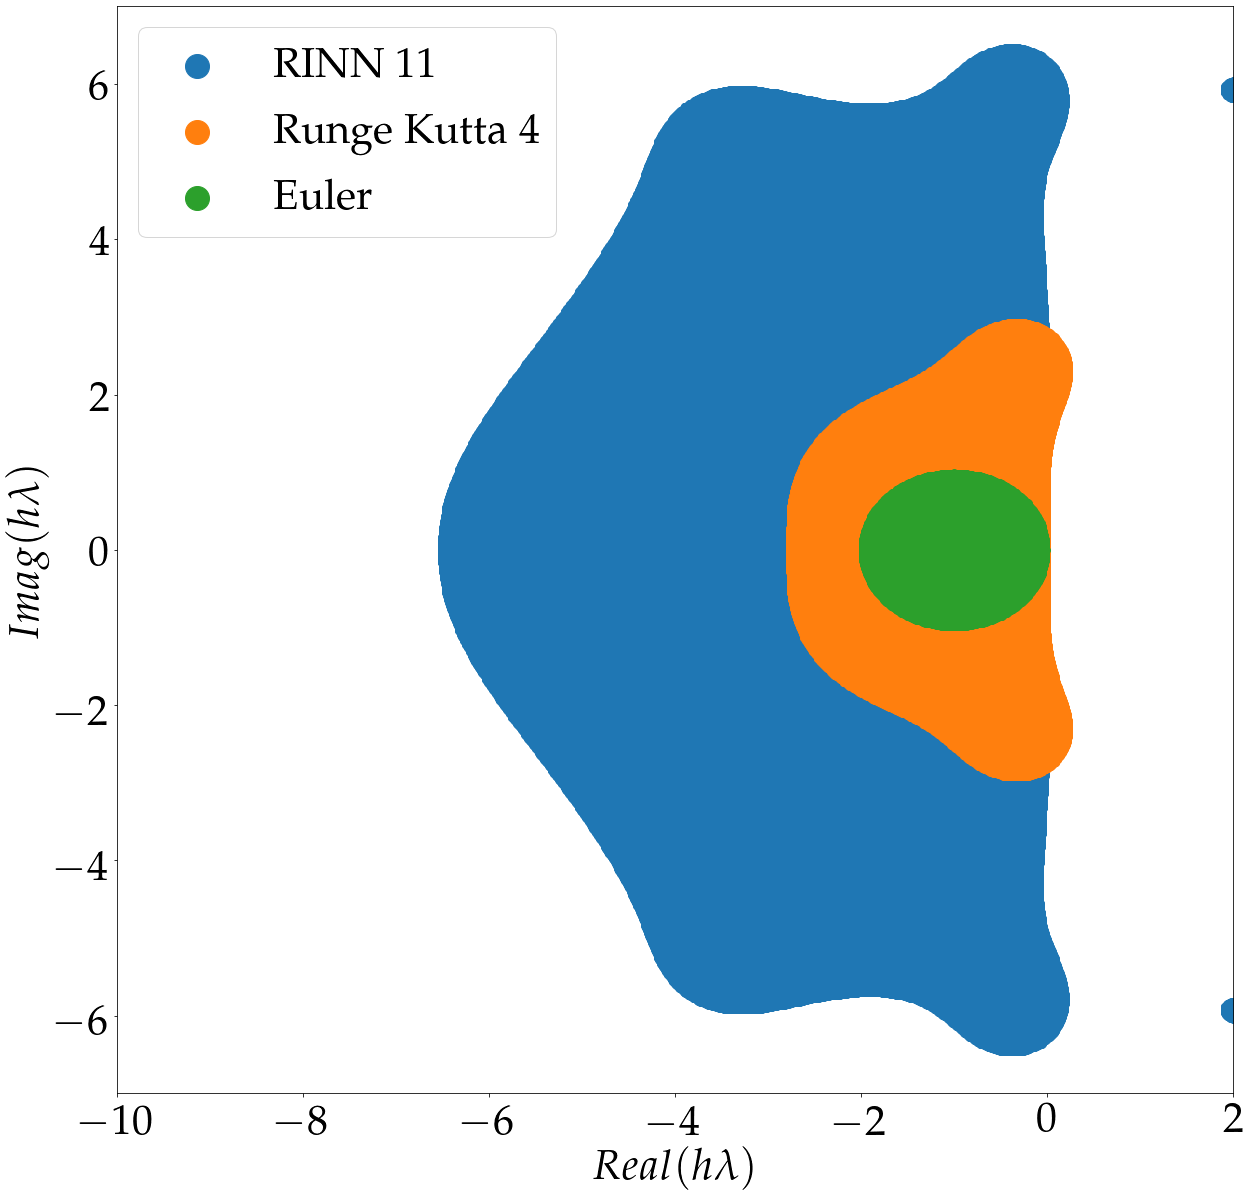

In [31]:
length_h = 1000
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(20,20))

plt.scatter(np.array(list_x),np.array(list_y), label = 'RINN 11')
plt.scatter(np.array(list_xRK4),np.array(list_yRK4), label = 'Runge Kutta 4')
plt.scatter(np.array(list_xE),np.array(list_yE), label = 'Euler')
plt.legend(markerscale=4.)
plt.xlabel('$Real(h\lambda)$')
plt.ylabel('$Imag(h\lambda)$')
plt.xlim(-10,2)
plt.ylim(-7,7)

# generalizability to time step

In [32]:
nb_steps_pred = 10000
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,params['dim_output']))
tmp = np.reshape(np.ones(3),(1,params['dim_output']))
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN(tmp,0.01,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,params['dim_output']))).float())

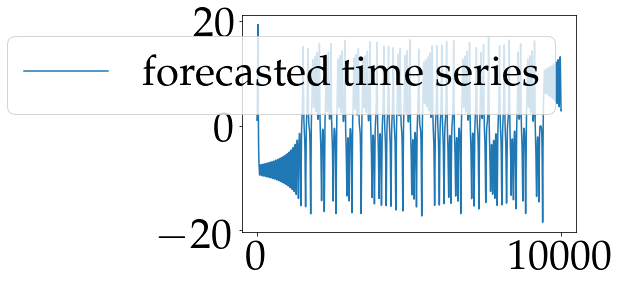

In [33]:
plt.plot(y_pred[1:,0], label = 'forecasted time series')
plt.legend()

Text(0.5, 0, '$z_3$')

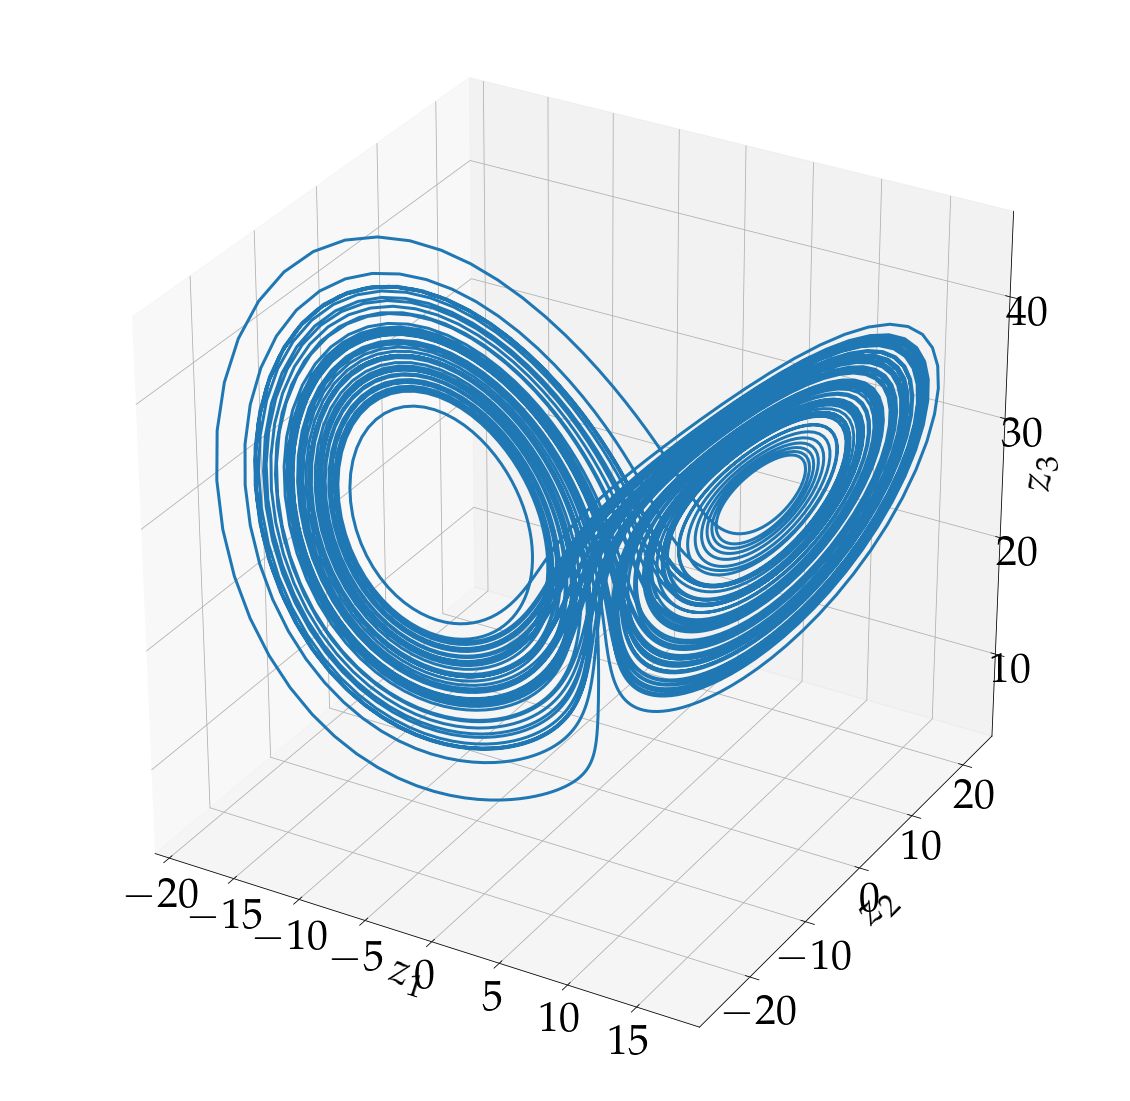

In [34]:
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
fig = plt.figure(figsize=(20,20))
ax=fig.gca(projection='3d')
line1,=ax.plot(y_pred[2000:,0],y_pred[2000:,1],y_pred[2000:,2],lw = 3)
ax.set_xlabel('$z_1$',labelpad = 11);ax.set_ylabel('$z_2$',labelpad = 11);ax.set_zlabel('$z_3$',labelpad = 11)

# Generalizability to model, test the RINN integration scheme on the Lorenz 96 model

In [35]:
nb_steps_pred = 400
t_pred = nb_steps_pred * GD.dt_integration
y_pred=np.zeros((nb_steps_pred,40))
tmp = np.ones((1,40))#np.reshape(catalog.analogs[0,:],(1,params['dim_output']))
tmp[0,20:] = 1+0.01
tmp = Variable(torch.from_numpy(tmp).float())

for i in range(nb_steps_pred):
    y_pred[i,:] = modelRINN.flow_True_Model_L96(tmp,0.05,order)[0].data.numpy()
    tmp = Variable(torch.from_numpy(np.reshape(y_pred[i,:] ,(1,40))).float())

<Figure size 360x360 with 0 Axes>

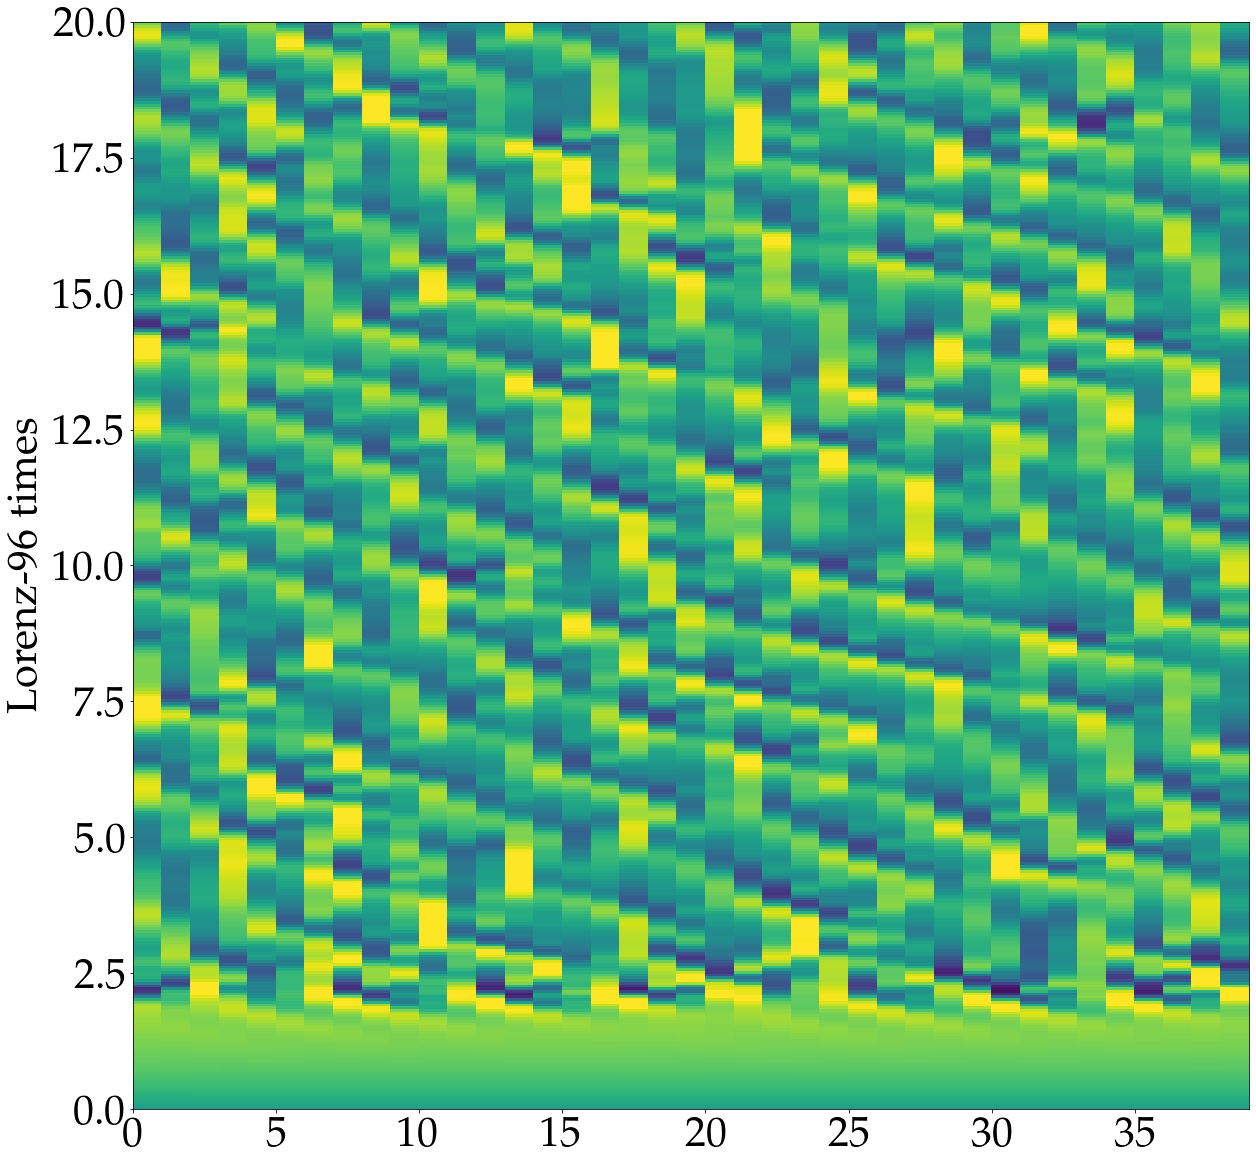

In [36]:
import matplotlib as mpl
plt.rcParams["mathtext.fontset"] = "cm"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 42})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
plt.figure(figsize=(5,5))
[X,Y]= np.meshgrid(range(40),np.linspace(0,nb_steps_pred*0.05,nb_steps_pred+1))
plt.figure(figsize=(20,20))
plt.pcolor(X,Y,y_pred);
plt.xlim([0,40-1]);
plt.clim([-10,10]);
plt.ylabel('Lorenz-96 times');

In [39]:
from tabulate import tabulate

In [40]:
print(tabulate(a, tablefmt="latex", floatfmt=".5f"))

\begin{tabular}{rrrrrrrrrrr}
\hline
  0.00000 &  0.00000 &  0.00000 &  0.00000 &  0.00000 & 0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  0.09168 &  0.00000 &  0.00000 &  0.00000 &  0.00000 & 0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
 -0.00598 &  0.09825 &  0.00000 &  0.00000 &  0.00000 & 0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
 -0.23044 &  0.00477 &  0.38754 &  0.00000 &  0.00000 & 0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
 -0.25781 & -0.20551 &  0.79426 & -0.16890 &  0.00000 & 0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
 -0.24147 &  0.53237 & -0.20302 &  0.46703 & -0.12458 & 0.00000 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  1.16600 & -0.60220 & -0.35233 & -0.56929 &  0.27263 & 0.51660 &  0.00000 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  0.34099 & -0.52091 &  0.27404 & -0.25958 &  0.25545 & 0.38264 &  0.13340 &  0.00000 & 0.00000 & 0.00000 & 0.00000 \\
  0.16978 & 

In [41]:
print(tabulate(b.reshape(1,-1), tablefmt="latex", floatfmt=".5f"))

\begin{tabular}{rrrrrrrrrrr}
\hline
 0.00010 & 0.00007 & 0.22873 & 0.00013 & 0.00020 & 0.27106 & 0.00003 & 0.00011 & 0.36341 & 0.04983 & 0.08633 \\
\hline
\end{tabular}


In [42]:
print(tabulate(c.reshape(1,-1), tablefmt="latex", floatfmt=".5f"))

\begin{tabular}{rrrrrrrrrrr}
\hline
 0.00000 & 0.09168 & 0.09227 & 0.16187 & 0.16204 & 0.43033 & 0.43142 & 0.60603 & 0.64954 & 0.84016 & 1.00000 \\
\hline
\end{tabular}
